# Validation of Exoplanet Signals using a Probabilistic Algorithm (VEPSA) Tutorial
*Tutorial created by Tim Morton (VESPA code author), Juliette Becker, Andrew Vanderburg*

----

This tutorial cracks open the black box of [vespa](vespa.rtfd.org), which is an implementation of the procedure described in [Morton (2012)](https://arxiv.org/abs/1206.1568) to compute the false positive probability of a transiting planet candidate.  

If a directory is [completely prepared](#Preparing-a-vespa-directory), running `vespa` consists of executing the following commands from a terminal:

    starfit --all <directory name>
    calcfpp <directory name>

The `starfit --all` command [estimates the stellar properties of the host star](#Fitting-stellar-models), and `calcfpp` [computes the false positive probability](#Calculating-FPP).


# Preparing a vespa directory

Running a `vespa` calculation requires creating `star.ini` and `fpp.ini` config files, as described below.


## Host star

Create a `star.ini` file containing the RA/Dec coordinates of the transit candidate host star, and any available observed properties, such as broadband photometric magnitudes, spectroscopic properties, or parallax.
All quantities are listed as `value, uncertainty`.
One of the magnitudes provided must be the band in which the transit was observed, and need not have an uncertainty (values without uncertainties will not be used in the model fitting).
Here is an example `star.ini` file:

    ra = 289.217499
    dec = 47.88446
    J = 10.523, 0.02
    H = 10.211, 0.02
    K = 10.152, 0.02
    g = 12.0428791, 0.05
    r = 11.5968652, 0.05
    i = 11.4300704, 0.05
    z = 11.393061, 0.05
    Kepler = 11.664
    Teff = 5642, 50.0
    feh = -0.27, 0.08
    logg = 4.443, 0.028

## Planet candidate

Create a text file containing the photometry of the detected candidate, detrended and phase-folded.
This file should have the following three columns in order:

  * Time from mid-transit, in units of days
  * Relative flux, normalized to unity; e.g., `flux / median(flux)`.
  * Relative flux uncertainty (also normalized)

The photometry should be limited to only those points within just a few transit durations of the transit, not the entire orbital phase.
This file may have any name, but for current purposes, let's call it `transit.txt`.

For a quick description of how to make a file like this for a new candidate, see [Appendix 1](#Appendix-1) of this notebook. 

You can check to make sure that this is put together correctly by using the utilities provided in and used by `vespa` to load and visualize the candidate:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from vespa import TransitSignal
trsig = TransitSignal.from_ascii('TestCase1/transit.txt')
trsig.plot()

The results of three other analyses (calculations that `vespa` does not do) must also be provided:

  - A best-fit estimate of the planet/star radius ratio.

  - An observational upper limit on the depth of a potential secondary eclipse in the light curve.
    This may be calculated by, e.g., running a transit search in the light curve at other phases but keeping the period fixed.

  - A limit on the furthest angular separation from the target star that a potential blending star might reside.
    This limit should come from pixel-level analysis of the target star photometry, establishing that the signal does not originate from a different star.
    While the tightest constraint will come from some kind of centroid or pixel-modeling effort (e.g. [Bryson et al, 2013](https://arxiv.org/pdf/1303.0052.pdf)), it should also be sufficient to test the depth of the signal as a function of aperture size, to see whether the measured depth is aperture-dependent (that is, if the signal is caused by a small amount of flux from a bright eclipsing binary many pixels away from the target, then the signal will be deeper with larger apertures.)
    A good example of what can happen if this analysis is not done carefully is with EPIC210400868 from [Cabrera et al., 2017](https://arxiv.org/pdf/1707.08007.pdf).

All of this information gets summarized in another config file: `fpp.ini`, as follows:

    name = K00087.01
    ra = 289.217499
    dec = 47.88446
    period = 289.864456     # Orbital period of candidate
    rprs = 0.021777742485   # Planet/star radius ratio
    photfile = transit.txt  # File containing transit photometry

    [constraints]
    maxrad = 1.05           # Maximum potential blending radius, in arcsec
    secthresh = 9.593e-05   # Maximum allowed secondary eclipse depth

# Fitting stellar models

The first step of a `vespa` calculation is to fit the stellar parameters to the observed properties of the star.
Before this step, the directory should look like this:

    $ ls TestCase1
    fpp.ini
    star.ini
    transit.txt


Fitting the stellar properties consists of running the `starfit` script, which is part of the `isochrones` package:

Run in a bash terminal:

    $ starfit --all TestCase1

This script performs three different fits: single-, binary- and triple-star models.
It should take approximately 25 minutes to run: about 3, 7, and 15 minutes for the single, binary, and triple models, respectively.
After the script finishes, your directory should look like:

In [ ]:
%%bash
ls TestCase1/

The `mist_starmodel_*.h5` files contain the samples from the posterior probability distribution of the model parameters, as well as samples of derived parameters.
You can load the stellar model as follows:

In [ ]:
from isochrones import StarModel    
mod_single = StarModel.load_hdf('TestCase1/mist_starmodel_single.h5')

This is the object used to fit the stellar model.  The parameters it fits for are the following:

In [ ]:
mod_single.param_names

The binary star model fits for two stars, as follows:

In [ ]:
mod_binary = StarModel.load_hdf('TestCase1/mist_starmodel_binary.h5')
mod_binary.param_names

You can investigate the posterior samples of the model parameters, as well as many derived parameters, via the `.samples` attribute:

In [ ]:
mod_single.samples.head()

The `*.png` files created by `starfit` in the directory contain diagnostic plots.
There are two kinds of "corner" plots that show the joint distributions of various parameters: `*_physical.png` and `*_observed.png`.
The "physical" plots show the distribution of the physical parameters of the star(s) resulting from the model fits: mass, radius, age, [Fe/H], distance, and extinction.  (Radius is the only of these that is a derived parameter, rather than a directly fitted parameter.)

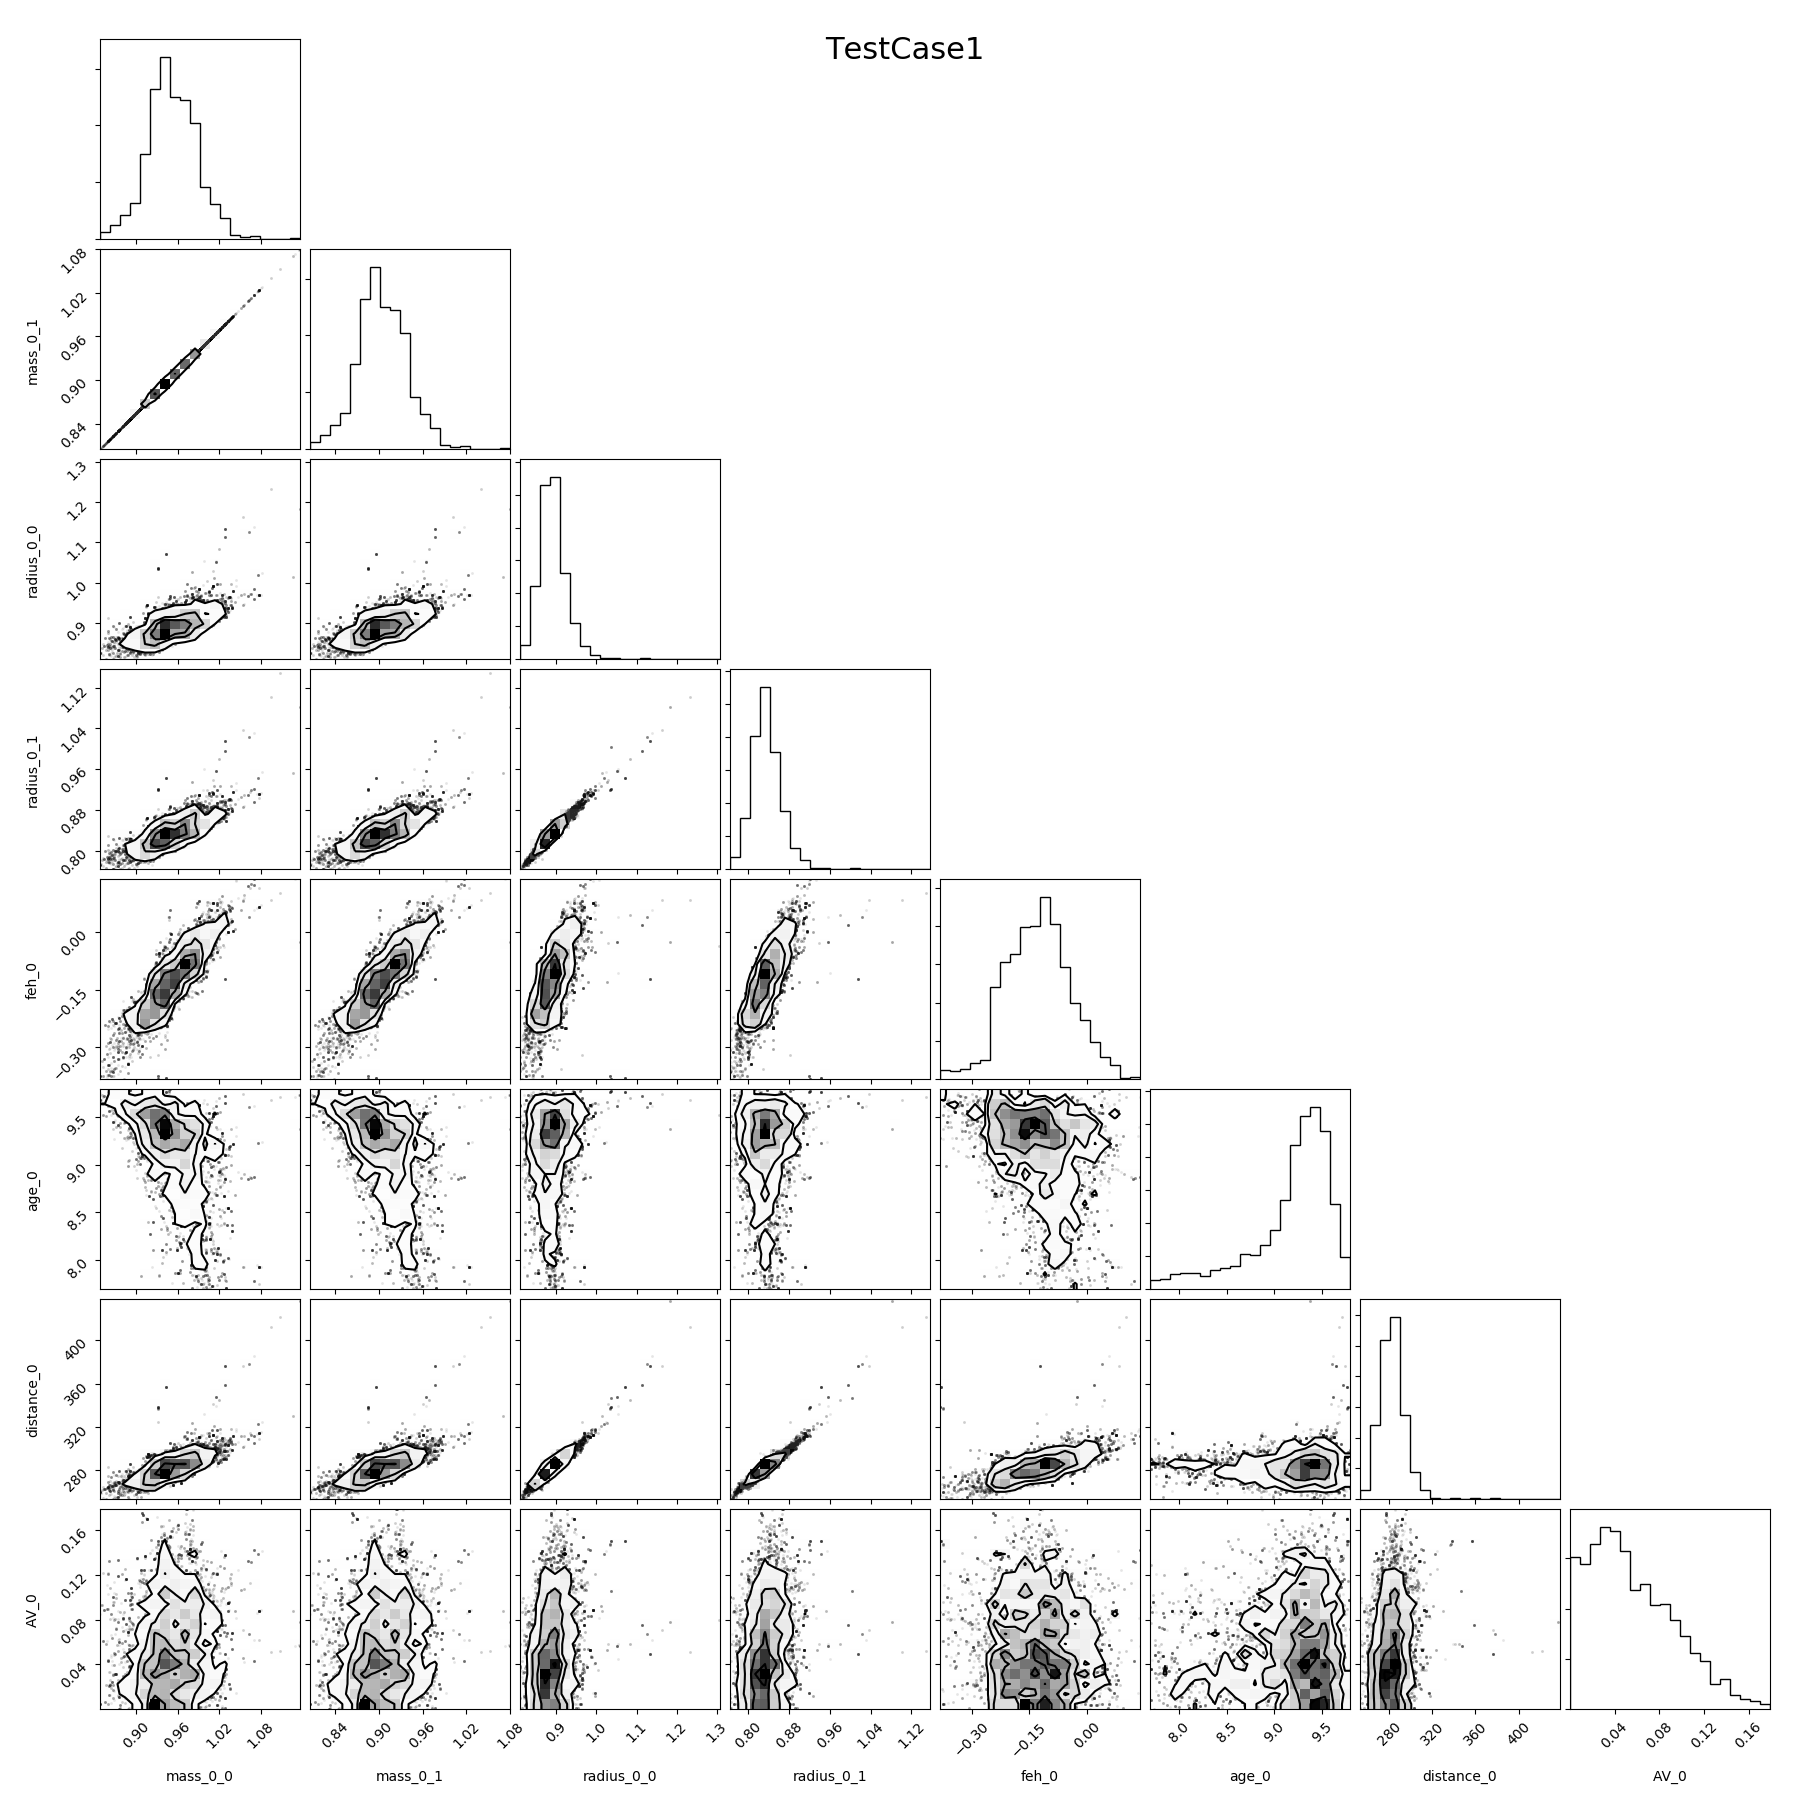

In [1]:
from IPython.display import Image
Image("TestCase1/mist_corner_binary_physical.png")

Note how the posterior distribution of secondary star mass (`mass_0_1`), and system distance (`distance_0`) is bimodal.  Think about this bimodality.  Can you explain why it is there?

Now, look at `mist_corner_triple_physical.png`.  Do you see a similar feature? 

In [ ]:
# Display the image of the new figure:



The "observed" plots show the distribution of the derived parameters of the model that correspond to the quantities used to constrain the models; in this case, seven photometric bands and three spectroscopic parameters.
These figures also show the provided constraint values (blue lines), which can be indicative of a poor stellar model fit if they do not lie comfortably within the distribution of the modeled parameters.

In [ ]:
Image("TestCase1/mist_corner_binary_observed.png")

In [ ]:
# There are other figures in the folder that show the VESPA results. You can
# look at these with:

#  Image("TestCase1/<filename>")

# Calculating FPP

With the stellar model fits complete, you can now calculate the false positive probability by executing the following in a terminal:

    $ calcfpp TestCase1

If you want to do a quicker test run, you can run `calcfpp -n 1000` (for example), to make smaller populations (the default `n` is 20000, which takes about 10 minutes).

[Morton (2012)](http://adsabs.harvard.edu/cgi-bin/nph-data_query?bibcode=2012ApJ...761....6M&link_type=PREPRINT&db_key=AST) describes the procedure that `vespa` uses to calculate the false positive probability (FPP) of a planet candidate.  In short, the calculation is as follows:

$$  {\rm FPP} = 1 - P_{\rm pl}, $$

where

$$  P_{\rm pl} = \frac{\mathcal L_{\rm pl} \pi_{\rm pl}}
                                 {\mathcal L_{\rm pl} \pi_{\rm pl} +
            \mathcal L_{\rm FP} \pi_{\rm FP}}. $$
            
The $\mathcal L_i$ here represent the "model likelihood"
factors and the $\pi_i$ represent the "model priors," with the
${\rm FP}$ subscript representing the sum of $\mathcal L_i \pi_i$ for each of the false positive scenarios.  A brief description of how the likelihoods and priors for each of the models are calculated can be found in the [vespa online documentation](http://vespa.readthedocs.io/en/latest/fpp.html).

If you follow along with the output of `calcfpp`, you will notice it first fits the trapezoid model to the observed transit signal.
It then proceeds to generate populations for lots of different models, and subsequently to fit a trapezoid model to each instance.
By default, `calcfpp` will use the following models:

  * BEB (background(/foreground) eclipsing binary---physically unassociated with target star)
  * HEB (hierarchcial eclipsing binary)
  * EB (eclipsing binary---the target star is an EB, no additional blending)
  * Pl (planet: the true transiting planet model)

There are also `_Px2` versions of the EB models, in which the false positive scenario has a period exactly twice the candidate's period, which could happen if the primary and secondary EB eclipse depths are very similar.

After running `calcfpp`, you now have the following files in your directory:

In [ ]:
%%bash
ls TestCase1

Again, we see `*.h5` and `*.png` files have been created.

One interesting file is the `starfield.h5` file, which contains the TRILEGAL simulation of the background population of stars, used in the BEB model population.
The purpose of this file is to simulate the stellar photometry of the field.
Let's take a look at its contents:

In [3]:
import pandas as pd
starfield = pd.read_hdf('TestCase1/starfield.h5','df')

# let's look at the columns of this simulation:
starfield.columns  

Index(['Gc', 'logAge', '[M/H]', 'm_ini', 'logL', 'logTe', 'logg', 'm-M0', 'Av',
       'm2/m1', 'mbol', 'Kepler_mag', 'g_mag', 'r_mag', 'i_mag', 'z_mag',
       'DDO51_finf_mag', 'J_mag', 'H_mag', 'Ks_mag', 'Mact'],
      dtype='object')

These are the quantities simulated in the field. We can also plot the HR diagram of all the objects in the field:

Text(0,0.5,'Log(L / L$_{sun}$)')

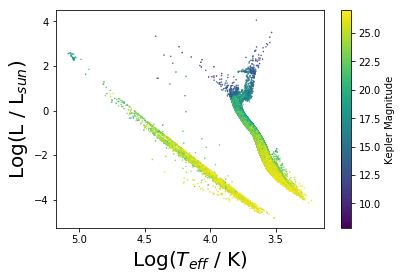

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(starfield['logTe'], starfield[u'logL'],marker='.',
     c = starfield[u'Kepler_mag'],s=1)
plt.gca().invert_xaxis()
plt.colorbar(label="Kepler Magnitude")
plt.xlabel("Log($T_{eff}$ / K)", fontsize=20)
plt.ylabel("Log(L / L$_{sun}$)", fontsize=20)

# So, what we see here is the HR diagram for the simulated star field. 

# more details on how simulation is run:
#  http://stev.oapd.inaf.it/~webmaster/trilegal_1.6/help.html

`popset.h5` contains the simulated populations, and can be loaded as follows:

In [ ]:
from vespa import PopulationSet
popset = PopulationSet.load_hdf('TestCase1/popset.h5')

Individual populations can be accessed from this object as follows:

In [ ]:
ebs = popset['eb']
bebs = popset['beb']
hebs = popset['heb']
pls = popset['pl']

Each of these population objects has a `.stars` attribute that contains all of the data for all the simulated instances of that model.  Investigate this `.stars` dataframe a bit.  For two different populations, make scatter plots of different columns to see if you can see interesting distributions.  You may wish to pay special attention to the `depth`, `duration`, and `slope` columns, which are the parameters of the trapezoid shape model. The different distributions of these parameters for the different populations is what allows us to distinguish between planet and false positive models.  

In [ ]:
# Your code here





As before, `*.png` files are diagnostic figures.  `FPPsummary.png` displays the summary of the results:

In [ ]:
Image('TestCase1/FPPsummary.png')

The others are informative visualizations of the various models, showing the distribution of simulated trapezoidal model parameters compared to the trapezoidal fit to the true transit candidate signal; for example:

In [ ]:
Image('TestCase1/eb.png')

In [ ]:
Image('TestCase1/pl.png')

You can also directly load the `FPPCalculation` object from this directory:

In [ ]:
from vespa import FPPCalculation
fpp = FPPCalculation.load('TestCase1')

At this point, you should be able to quickly get the false positive probability result:


In [ ]:
fpp.FPP()

The calculation is quick this time (it only takes ~1 minute, compared to the much longer computation when you first ran `calcfpp` from terminal) because the populations are already generated, and the likelihood computations have been cached.

In [ ]:
# There are other figures in the folder that show the VESPA results. You can
# look at these with:

#  Image('TestCase1/<filename>'')

# Appendix 1
### Preparing the input files for your own system(s)
As noted above, VESPA requires a detrended, flattened, phase-folded lightcurve to work. [As described here](https://github.com/barentsen/kepler-athenaeum-tutorial/blob/master/how-to-find-a-planet-tutorial.ipynb), the process of finding a planet requires several steps before you get to the point where you have a phase-folded, flattened light curve (like the kind you need for VESPA). Let's try the steps [from this tutorial](https://github.com/barentsen/kepler-athenaeum-tutorial/blob/master/how-to-find-a-planet-tutorial.ipynb) and flatten a light curve.

First, let's take a sample light curve from the K2 mission. Let's try the one at [this URL](https://www.cfa.harvard.edu/~avanderb/k2c14/ep248463350.html), EPIC 248463350. You can download it from the website, or you can use the file `Data/raw248463350.txt` which is available on your machine.

The ExoFop page for this source is [at this link](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=248463350). 
You will need some of the stellar parameters and imaging observations to make the `star.ini` file. 

Save the files you will need on this target (or a different one, if you repeat the process) to your Data directory, and let's plot it and see what it looks like:


### Make the transit.txt file

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
epic_target = pd.read_csv('Data/raw248463350.txt', skiprows=1,names=['time','flux', 'error'])
plt.errorbar(epic_target['time'], epic_target['flux'],epic_target['error'])
plt.ylabel("Flux", fontsize=20)
plt.xlabel("Time", fontsize=20)


This light curve has long term trends (what could those be due to?). For finding planets, they are not very helpful. So, we will use a low pass filter to remove them:

In [ ]:
import scipy.signal
trend = scipy.signal.savgol_filter(epic_target['flux'], 101, polyorder=3) 
epic_target['corr_flux'] = (epic_target['flux'] / trend)

plt.plot(epic_target['time'], epic_target['corr_flux'], '.')
plt.ylabel("Flux (flattened)", fontsize=18)
plt.xlabel("Time", fontsize=18)
plt.ylim(0.9978, 1.001)

You will notice that this low pass filter is not perfect (the bumps near each transit arise because we did not remove near transit points, and without removing those points we can't use this curve for real science, only for a quick look at what's going on in the light curve), but it has turned the messy light curve into a flattened curve with a few events that look like transits. At this point, we need to figure out the periods of the planets, so we know which periods to fold over to generate the `transit.ini` files for VESPA. For details on how to do this, you can go to the EXOFAST tutorial at this workshop (or read about it online [here](https://exoplanetarchive.ipac.caltech.edu/docs/exofast/exofast_recipe_2.html)). Let's assume that you asked your collaborator (who attended the EXOFAST workshop) to do the fit for you, and they sent back the following parameters:

| Quantity | Planet 1 | Planet 2 |
|------|------|------|
|   Period (days)  | 6.393653 | 18.788228|
|   Time of center transit (days)  | 2457941.008880 | 2457930.470510 |
|   R_p/R_star (fractional)  | 0.036485216 | 0.017301727 |
|Transit Duration (days)| 0.14959668| 0.18613987|


Using those parameters, you now know that there are two planets in the system. Your collaborator also sent back a flattened light cruve with different columns corrsponding to different planets (with events where multiple transits occur simultaneously excluded), which we will use going forward in place of the imperfect low pass filter from before. 

In [ ]:
# Values your collaborator sent:
planet_no = [2,1]
periods = [6.393653, 18.788228] #days
tcent = [2457941.008880,2457930.470510] # days
rp_rs = [0.017301727,0.036485216] # fractional
durations = [0.14959668, 0.18613987] #days

# Your collaborator from the EXOFAST workshop also sent you this version of the lightcurve, where they
# removed the transit events that occur at the same time (last two columns) for use with VESPA.
headings = ['Time', 'Relative Flux', 'Flattened Relative Flux', 'Flattened Relative Flux with planet 2 removed',
           'Flattened Relative Flux with planet 1 removed']
epic_target_fitted = pd.read_csv("Data/processed248463350.csv", delimiter=",", skiprows=1,names = headings,engine='python',index_col = None)


Now, we can try plotting the modded curves for planet(s) in the system. We will take a look at one planet (the first one, with the 6 day period) to start with, and you can try the other on your own. 

In [ ]:
plt.plot(epic_target_fitted['Time'].values % periods[0], epic_target_fitted['Flattened Relative Flux with planet 1 removed'].values, '.')
plt.ylabel("Flux (flattened)", fontsize=18)
plt.xlabel("Time", fontsize=18)

This is good, because we now have a folded, flattened light curve! However, take a look back at the transit curve in the example in this notebook. We don't really need all that flat continuum, so let's trim the transit around its center. Make sure to leave continuum equal to about the duration of the transit event on each side of the transit:

In [ ]:
# Note: if you look in the raw fit file, you'll notice the times given are BJD - 2454833. 
phased_time = (epic_target_fitted['Time'].values  - tcent[0] + 2454833  +periods[0] / 2 ) % periods[0] - periods[0] / 2
epic_target_fitted['Phased Time'] = phased_time
idx = (epic_target_fitted['Phased Time'] > -0.5) & (epic_target_fitted['Phased Time'] < 0.5)
plt.plot(epic_target_fitted.loc[idx]['Phased Time'], epic_target_fitted.loc[idx]['Flattened Relative Flux with planet 1 removed'].values, '.')
plt.ylabel("Flux (flattened)", fontsize=18)
plt.xlabel("Time", fontsize=18)

We need to write this curve to `transit.txt`:

In [ ]:
new_df = pd.DataFrame({"1":epic_target_fitted.loc[idx]['Phased Time'], 
                       "2":epic_target_fitted.loc[idx]['Flattened Relative Flux with planet 1 removed'].values},
                      )
new_df.to_csv("Example/transit.txt", index = False, header=False)

### Make the fpp.ini file

Recall, the `fpp.ini` files looked something like this:


In [6]:
%%bash
less TestCase1/fpp.ini

name = K00087.01
ra = 289.217499
dec = 47.88446
rprs = 0.021777742485
period = 289.864456
photfile = transit.txt
[constraints]
maxrad = 1.05
secthresh = 9.593e-05

We would like to make a similar file, which includes all known constraints on this system, for EPIC 248463350. You can find a lot of the information that you need at the ExoFop page for this source [here](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=248463350). 

Try creating this file, including the information from ExoFop and the values your collaborator sent you. 

The first set of parameters (`name`, `ra`, `dec`) you can get from ExoFop. 

`Rprs` (the radius of the planet over the radius of the star) and the `period` should be derived from the fit to the lightcurve. 

`Maxrad` is the aperture radius in arcsec. To find this value, we first need to know how many pixels are in the photometric aperture, which requires knowing what the aperture looks like. Go to [this page](https://www.cfa.harvard.edu/~avanderb/k2c14/ep248463350.html) and scroll to the bottom, and look at the pixel file (which is also reproduced in the next cell). 

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('Data/pixelfile.png')
plt.imshow(img)
plt.axis('off')

Count the pixels in the aperture.  Then, since the Kepler platescale is 3.98 arcseconds per pixel, convert to arcseconds and solve for the radius of the aperture. Once that radius is found, add the Kepler PSF (6 arcseconds) to be safe, and you have the value for `maxrad` that should be added to `fpp.ini`. 


In [ ]:
pixels = 21
arsecsq = pixels * 3.98**2.0
radius = np.sqrt(arsecsq / np.pi)
effective_radius = radius + 6
print("MAXRAD:", effective_radius)

---
**NOTE**

It is very important to understand that the `vespa` calculation assumes that there are no other known stars other than the target star within this aperture.  If there *are* other known stars and you ignore this fact, then you run the risk of underestimating the FPP of the transit candidate.

---

*Next* - `secthresh` is the maximum allowed depth of potential secondary eclipse. This should be computed from the lightcurve. Following the method in [Morton et al. (2016)](https://arxiv.org/pdf/1605.02825.pdf), this can be derived by searching the phased-folded light curve for the deepest signal at any other phase other than that of the primary transit. See also Section 3.2.2 of [Rowe et al. (2015)](http://iopscience.iop.org/article/10.1088/0067-0049/217/1/16/pdf). 

In this tutorial, we implement a simplified version of this method by taking the light curve, phase folding it with our fitted orbital period, and checking the depth of the expected bottom of transit near the expected center of secondary eclipse.



In [ ]:
# Plot the phased light curve again: 
plt.plot(epic_target_fitted['Phased Time'], epic_target_fitted['Flattened Relative Flux with planet 1 removed'].values, '.')
plt.ylabel("Flux (flattened)", fontsize=18)
plt.xlabel("Time (phased, days)", fontsize=18)


Next, look at the event depth at locations near where you expect the secondary transit event to be, keeping all other light curve parameters the same. In the plot below, we highlight the entire region where a secondary transit would occur, if it were visible. 

In [ ]:
# Note: if you look in the raw fit file, you'll notice the times given are BJD - 2454833. 
offset_phased_time = (epic_target_fitted['Time'].values  - tcent[0] + 2454833 ) % periods[0] - periods[0] / 2
epic_target_fitted['Offset Time'] = offset_phased_time
idx = (epic_target_fitted['Offset Time'] > -0.5*durations[0]) & (epic_target_fitted['Offset Time'] < 0.5*durations[0])
plt.plot(epic_target_fitted.loc[idx]['Offset Time'], epic_target_fitted.loc[idx]['Flattened Relative Flux with planet 1 removed'].values,'.', color='k',  label="Where Secondary should be")
plt.plot(epic_target_fitted['Offset Time'], epic_target_fitted['Flattened Relative Flux with planet 1 removed'].values, '.', color='k',alpha=0.1, label="all data")
plt.ylabel("Flux (flattened)", fontsize=18)
plt.xlabel("Time (phased, days)", fontsize=18)
plt.legend()

However, the plot above highlights the entire duration. What we really want to check is the average flux during the true eclipse event, excluding ingress and egress. So, splitting up the lightcurve near the location of the secondary event and taking the mean of only the 'flat' region of the eclipse should yield the limit on how deep the secondary eclipse could be.

In [ ]:
idx_ineg = (epic_target_fitted['Offset Time'] > -0.5*durations[0]) & (epic_target_fitted['Offset Time'] < 0.5*durations[0])
idx_event = (epic_target_fitted['Offset Time'] > -0.25*durations[0]) & (epic_target_fitted['Offset Time'] < 0.25*durations[0])
plt.plot(epic_target_fitted.loc[idx_ineg]['Offset Time'], epic_target_fitted.loc[idx_ineg]['Flattened Relative Flux with planet 1 removed'].values,'.', color='r', alpha=0.5, label="(Expected) ingress/egress, start of event")
plt.plot(epic_target_fitted.loc[idx_event]['Offset Time'], epic_target_fitted.loc[idx_event]['Flattened Relative Flux with planet 1 removed'].values,'.', color='DarkBlue',  alpha=0.5, label="(Expected) transit")
t = epic_target_fitted.loc[idx_event]['Offset Time']
mean_flux = np.mean(epic_target_fitted.loc[idx_event]['Flattened Relative Flux with planet 1 removed'].values)
plt.plot(t,len(t) * [mean_flux], label="Mean flux level in event", color='DarkBlue')
plt.ylabel("Flux (flattened)", fontsize=18)
plt.xlabel("Time (T$_{sec, expected}$ - t, days)", fontsize=18)
plt.legend()

The maximum secondary depth we use is Eq. 3 of Morton et al. 2016:

$\delta_{max} = \delta_{sec} + 3\sigma_{sec}$

where δsec is the fitted depth and σsec is the uncertainty
on that depth.
When you are preparing for publication, you will want to compute your uncertainty uniquely, but in this tutorial we will just use the scatter in the observed depths (when said depths are computed over a variety of phases).

Now, the true secondary eclipse may not be at exactly 0.5 phase, so we need to check the entire non-transiting region and take the deepest event. We do this by repeating the analysis we just did, but assuming that the secondary eclipse may occur at any time, so using a wide variety of 'center' eclipse locations. The deepest 'eclipse' from the results of this grid search will then be taken as the limit of the depth for the secondary eclipse. Then, we can compute the uncertainty on the eclipse depth by taking the standard deviation of all these values. 

We perform this grid search as follows:

In [ ]:
# get the uncertainty on the depth
mean_flux_array = []
for dayval in np.linspace(-0.4*periods[0], 0.4*periods[0], 100):
    offset_phased_time = (epic_target_fitted['Time'].values  - tcent[0] + 2454833) % periods[0] - periods[0] / 2
    idx_event = (epic_target_fitted['Offset Time'] > -0.25*durations[0] - dayval) & (epic_target_fitted['Offset Time'] < 0.25*durations[0] - dayval)
    mean_flux_array.append(np.mean(epic_target_fitted.loc[idx_event]['Flattened Relative Flux with planet 1 removed'].values))
    # uncomment these to plot the locations you're testing:
    #plt.plot(epic_target_fitted.loc[idx_event]['Offset Time'].values,epic_target_fitted.loc[idx_event]['Flattened Relative Flux with planet 1 removed'].values,'r.')
    #plt.plot(epic_target_fitted['Offset Time'], epic_target_fitted['Flattened Relative Flux with planet 1 removed'].values, '.', color='k',alpha=0.1, label="all data")
    #plt.figure()
sigsec = np.std(mean_flux_array) # get overall uncertainty by taking standard deviation of all non-transit flux

# choose the deepest depth you found
dsec = 1 - min(mean_flux_array)

# Compute the secondary limit
dmax = dsec + 3 * sigsec

So, the final limit for the secondary eclipse depth will be:

In [ ]:
print("SECTHRESH", dmax)

This value gives the threshold to which a secondary transit can be excluded. You can also add this to `fpp.ini`. 

After adding all these parameters to the `fpp.ini` file, you will have a complete file that looks like the example. You can check your work by looking at the `fpp.ini` file in the 'Examples' folder, but make sure to give it a try yourself first. 



### Make the star.ini file
You can also use the information on ExoFop to make this file. Recall what it looks like:

In [5]:
%%bash
less TestCase1/star.ini

J = 10.523, 0.02
H = 10.211, 0.02
K = 10.152, 0.02
Kepler = 11.664
Teff = 5642, 50.0
feh = -0.27, 0.08
logg = 4.443, 0.028
maxAV = 0.187
g = 12.0428791, 0.05
r = 11.5968652, 0.05
i = 11.4300704, 0.05
z = 11.393061, 0.05


This file has magnitudes (J, H, K, Kepler; g, r, i, z) and stellar properties derived from a stellar spectrum (Teff, feh, logg), and you can also add the RA/DEC of the source (which must be supplied in `fpp.ini` but is an optional argument here). 

Create this file from the values on ExoFop, which come from the results of an analysis of the spectra. You can check your work by looking at the star.ini file in the 'Examples' folder, but make sure to give it a try yourself first. 

Look at the different information available on ExoFop. 

*If time allows*: How does changing the solution used (there are two spectral analyses for this particular star) change the final result? Try using the 2017 stellar parameters and check by how much that changes the final result of VESPA. Also, see how things change if you take away the spectroscopic contraints and only fit the stellar models using photometry.

---
Now, you can run the final VESPA analysis on this system (this might take a while - recall that you can lower the number of iterations using the argument -n X, when X is the number of iterations you want to run.). 

Make sure the change the directory to be wherever you put the files you just made. If you're using our premade versions, then use folder `Example`; in the sample command below, we assumed you put the files in the `Data` directory..

Run in a bash terminal:
>`starfit --all Data`

>`calcfpp Data`


### Part 2 (if time allows): Now, try to make the files for the other planet in this system. 
You can use the tutorial above as a starting point, and change the code as needed to derive the probabilities for Planet 2. 



In [ ]:
# First, plot the entire light curve and see if you can pick out the transit event. 



In [ ]:
# Next, phase fold the light curve using the orbital period. Make sure to use the version that has the
# other planet removed. 




In [ ]:
# Plot it and decide how much you need to trim.




In [ ]:
# Trim the light curve; plot it to make sure you did it right, and save it to the transit.txt file. 




In [ ]:
# Create the fpp.ini file. Can you use the same file that you did for the last planet? What do you need to change about it?




In [ ]:
# Create the star.ini file. Can you use the same file that you did for the last planet? What do you need to change about it?




In [ ]:
# Now, run the final analysis using starfit and calcfpp.




# Appendix 2
### Extra contraints

You may find that you have additional constraints in addition to the measurements discussed above. These additional constraints can also be added into VESPA. 

## Contrast curves
Contrast curves are generated by adaptive optics imaging observations. They inform us the limit on the relative brightness of any nearby sources, and can be used to rule out the presence of nearby stars at certain radii brighter than some amount. The contrast curve quantifies each of those values. 

For the target we've been studying in Appendix 1, the contrast curve is available [on ExoFop](https://exofop.ipac.caltech.edu/k2/files/248463350/Image/248463350I-dc20171227K_plot.tbl). It has also been copied to your Data directory, but you can look at the online file to see what the fields mean and more details about the observation.

In [ ]:
from vespa.stars.contrastcurve import ContrastCurveFromFile
cc = ContrastCurveFromFile('Data/Keck_k.cc', 'k')
cc.plot()

Your `fpp.ini` file can be fixed to include this curve as a contraint, as well. Currently, your file should contain the properties you derived above (secthresh and maxrad):

In [ ]:
%%bash
more Example/fpp.ini

But you can add another line at the bottom of the `fpp.ini` that includes the file containing the contrast curve:

    ccfiles = Keck_K.cc

After which you can run VESPA as normal. NOTE: you must include the contrast curve file in the directory containing your `fpp.ini` and `star.ini` files. 


You can also add a contrast curve as a constraint if you are loading a previously run false positive calculation and want to add the constrast curve as a further constraint:

In [ ]:
from vespa.stars.contrastcurve import ContrastCurveFromFile
from vespa import FPPCalculation

f = FPPCalculation.load('TestCase1') #or whichever directory you want to load
f.FPP() # Just to see what it is before doing anything else

In [ ]:
cc = ContrastCurveFromFile('Data/Keck_k.cc', 'K')
bebs = f['beb']
bebs.apply_cc(cc)
f.FPP()

Comparing those two probabilities, you can see how the FPP decreases with the addition of the contrast curve. 

## Limits on background stars

The Palomar Observatory Sky Survey (POSS) took images of the sky (on photographic plates) which have since been digitized. These images can provide useful constraints: for example, you might be able to say "there are no background stars brighter than X magnitude at Y angular separation" by looking at the region near a target on the digitized POSS observation of that region of the sky. Other observations and survey results (ex: SDSS) might also allow the same type of constraint on the presence of background stars.

To place limits on the presence of nearby background stars, you can treat your contraint as a contrast curve, by creating a text file. An example is given in Data/POSS_sample.cc:

In [ ]:
%%bash 
more Data/POSS_sample.cc

Recall, the first column is the angular separation from the source (in arcseconds), and the second column is the magnitude contrast exclusion. For the file to be accepted as a contrast curve, it must have at least four lines. In the case that you want to constraint background stars out to some distance, just make the top line:

    0 5
which means that you have no sources with more than 5 magnitudes of contrast at 0 arcsec separation, and then make the final line:

    10 5
which means that you have no sources with more than 5 magnitudes of contrast at 10 arcsec separation. The two intermediate lines should have the same magnitude limit, and separation values in between the upper and lower limit (to allow the fit to succeed). 

Once you have created this file, you can add it as a contrast curve.

In [ ]:
from vespa.stars.contrastcurve import ContrastCurveFromFile
cc = ContrastCurveFromFile('Data/POSS_sample.cc', 'K') # include waveband of constraint

Then, you will want to apply the constraint to the background eclipsing binary scenario, which will change the most with this new constraint. 

**Note**: you will not want to put `POSS_sample.cc` in the constraint list in the `fpp.ini`, because otherwise it will be automatically applied to all the scenarios (EB and HEB included, for which we do *not* want to rule out everything down to zero separation).

In [ ]:
bebs = f['beb']
bebs.apply_cc(cc)
f.FPP()

## Excluding false positive scenarios
You may find that you want to set the probability of certain false positive scenarios to be zero. For example, if you have radial velocity measurements, you may find that the curve has a low enough measured RV amplitude that you can rule out the scenario of an eclipsing binary (as a stellar companion would cause much larger RV variations than a planet would). In this case, you can set the probability of the eclipsing binary scenario to be 0. 

To do this, you pass argument `skipmodels` to the `FPP` method when computing the final probability. 

In [ ]:
# list the models being considered in the FPP calculation:
f.modelnames
# you can also check the short names of each:
# f.shortmodelnames

Using the name corresponding to the probabilty you wish to set to zero, you can skip that model when computing the FPP:

In [ ]:
f.FPP(skipmodels=['EBs', 'EBs (Double Period)']) #ignore the model(s) you can exclude 

# Appendix 3
### Reading fits files
(provided for reference - we will not go through this in the workshop, and projects will use reduced extracted light curves)

Above, we used a processed .csv file that contained the light curve from the source. You can also download the light curve from MAST, and if you do that, you get a fits file. Let's take a look at what the contents of that file look like:


In [ ]:
from astropy.io import fits
epic_fits = fits.open('Data/lc248463350.fits')

In [ ]:
# Check what's available in the file:
epic_fits.info()

In [ ]:
# The first extension contains the header:
epic_fits[0].header

In [ ]:
# The second extension contains the light curve, with a tuple of each data point. 
epic_fits[1].header

In [ ]:
# We can reformat this into an easily plottable format (check the header of this extension (above) if you need
# to know which column is which, and you can try plotting the other columns):
time = list(zip(*epic_fits[1].data))[0]
flux = list(zip(*epic_fits[1].data))[3] # aperture photometry flux (column #4 above), not corrected
plt.plot(time, flux)

In [ ]:
# Finally, the third extentsion contains the aperture image, which you can look visualize and inspect:
imshow(epic_fits[2].data)